In [46]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter

sys.path.append(os.path.abspath('..'))
from utils.utils_constants import ARTERY_TYPES, DISEASE_TYPES, VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH

SEVERITY_MAPPING = {
    '0:absent': 0,
    '1:mild (1-25%)': 1,
    '2:moderate (26-50%)': 2,
    '3:severe (>50%)': 3
}

CLININCAL_FEATURES = ['PAT_Sex', 'PAT_Hispanic', 'PAT_Cohort', 'PAT_Race', 'PAT_AgeV3', 'eGFRatBx', 'UPCRatBx', 
                      'Immunosupression_30dBfOrAtBx', 'ArterioSclerosis', 'ArterialHyalinosis']

In [2]:
def binary_map(x, positive_value):
    return 1 if x == positive_value else 0

In [3]:
pat_df = pd.read_csv(VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH)

# Applying the function to various columns
pat_df['PAT_Hispanic'] = pat_df['PAT_Hispanic'].apply(lambda x: binary_map(x, '1: Hispanic or Latino'))
pat_df['Immunosupression_30dBfOrAtBx'] = pat_df['Immunosupression_30dBfOrAtBx'].apply(lambda x: binary_map(x, '1: Yes'))
pat_df['PAT_Race'] = pat_df['PAT_Race'].apply(lambda x: binary_map(x, '3: Black/African American'))
pat_df['PAT_Sex'] = pat_df['PAT_Sex'].apply(lambda x: binary_map(x, '2: Female'))
pat_df['PAT_Cohort'] = pat_df['PAT_Cohort'].apply(lambda x: binary_map(x, '2 - MCD'))
pat_df['ArterioSclerosis'] = pat_df['ArterioSclerosis'].map(SEVERITY_MAPPING)
pat_df['ArterialHyalinosis'] = pat_df['ArterialHyalinosis'].map(SEVERITY_MAPPING)

covariates_to_normalize = ['PAT_AgeV3', 'eGFRatBx', 'UPCRatBx', 'ArterioSclerosis', 'ArterialHyalinosis']  # add numerical columns here
scaler = StandardScaler() # choose a scaler?
pat_df[covariates_to_normalize] = scaler.fit_transform(pat_df[covariates_to_normalize]) # in place

In [60]:
pat_df.shape

(198, 372)

In [5]:
SCORE_FEATURES = ['Max_Arteriosclerosis_Severity_in_Arterioles', 'Median_Hyalinosis_Severity_in_Arterioles', 
                  '75th_Arteriosclerosis_Severity_in_Interlobular_Arteries']
score_features = []  # Initialize an empty list to store feature names

for artery_type in ARTERY_TYPES:
    for disease_type in DISEASE_TYPES:
        for agg_metric in ["Max", "Median", "75th", "Mean", "NonZeroPct"]:
            score_feature_name = '_'.join([agg_metric, disease_type, "Severity", "in", artery_type])
            score_features.append(score_feature_name.replace(" ", "_"))
score_features

['Max_Arteriosclerosis_Severity_in_Arterioles',
 'Median_Arteriosclerosis_Severity_in_Arterioles',
 '75th_Arteriosclerosis_Severity_in_Arterioles',
 'Mean_Arteriosclerosis_Severity_in_Arterioles',
 'NonZeroPct_Arteriosclerosis_Severity_in_Arterioles',
 'Max_Hyalinosis_Severity_in_Arterioles',
 'Median_Hyalinosis_Severity_in_Arterioles',
 '75th_Hyalinosis_Severity_in_Arterioles',
 'Mean_Hyalinosis_Severity_in_Arterioles',
 'NonZeroPct_Hyalinosis_Severity_in_Arterioles',
 'Max_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Median_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 '75th_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Mean_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'NonZeroPct_Arteriosclerosis_Severity_in_Interlobular_Arteries',
 'Max_Hyalinosis_Severity_in_Interlobular_Arteries',
 'Median_Hyalinosis_Severity_in_Interlobular_Arteries',
 '75th_Hyalinosis_Severity_in_Interlobular_Arteries',
 'Mean_Hyalinosis_Severity_in_Interlobular_Arteries',
 '

In [6]:
measurement_features = []
feature_names = ['Intima Area Ratio',
#  'Media Area Ratio',
 'Hyalinosis Area Ratio',
#  'Intima Average',
#  'Intima Median',
#  'Intima Variance',
#  'Intima Peak Height',
 'Intima Peak Prominence',
#  'Media Average',
#  'Media Median',
#  'Media Variance',
#  'Media Peak Height',
#  'Media Peak Prominence',
 'Ratio Average',
 'Ratio Median',
 'Ratio Variance',
 'Ratio Peak Height',
 'Ratio Peak Prominence']

for feature_name in feature_names:
        for artery_type in ARTERY_TYPES:
                for agg_metric in ["Max", "Median", "75th", "Mean", "25th"]:
                        measurement_feature_name = '_'.join([agg_metric, feature_name, "in", artery_type])
                        measurement_features.append(measurement_feature_name.replace(" ", "_"))
measurement_features

['Max_Intima_Area_Ratio_in_Arterioles',
 'Median_Intima_Area_Ratio_in_Arterioles',
 '75th_Intima_Area_Ratio_in_Arterioles',
 'Mean_Intima_Area_Ratio_in_Arterioles',
 '25th_Intima_Area_Ratio_in_Arterioles',
 'Max_Intima_Area_Ratio_in_Interlobular_Arteries',
 'Median_Intima_Area_Ratio_in_Interlobular_Arteries',
 '75th_Intima_Area_Ratio_in_Interlobular_Arteries',
 'Mean_Intima_Area_Ratio_in_Interlobular_Arteries',
 '25th_Intima_Area_Ratio_in_Interlobular_Arteries',
 'Max_Intima_Area_Ratio_in_Arcuate_Arteries',
 'Median_Intima_Area_Ratio_in_Arcuate_Arteries',
 '75th_Intima_Area_Ratio_in_Arcuate_Arteries',
 'Mean_Intima_Area_Ratio_in_Arcuate_Arteries',
 '25th_Intima_Area_Ratio_in_Arcuate_Arteries',
 'Max_Hyalinosis_Area_Ratio_in_Arterioles',
 'Median_Hyalinosis_Area_Ratio_in_Arterioles',
 '75th_Hyalinosis_Area_Ratio_in_Arterioles',
 'Mean_Hyalinosis_Area_Ratio_in_Arterioles',
 '25th_Hyalinosis_Area_Ratio_in_Arterioles',
 'Max_Hyalinosis_Area_Ratio_in_Interlobular_Arteries',
 'Median_Hyalino

In [8]:
for x in CLININCAL_FEATURES+measurement_features:
    if x not in pat_df.columns:
        print(x)

In [9]:
pat_df.dropna(subset = CLININCAL_FEATURES+score_features + measurement_features, inplace = True)
pat_df['DaysBXtoESRDorEGFR40_LR'] = pd.to_numeric(pat_df['DaysBXtoESRDorEGFR40_LR'], errors='coerce')
pat_df['ESRDorEGFR40BX_LR'] = pat_df['ESRDorEGFR40BX_LR'].map({'1: Yes': 1, '0: No': 0}).astype(int)

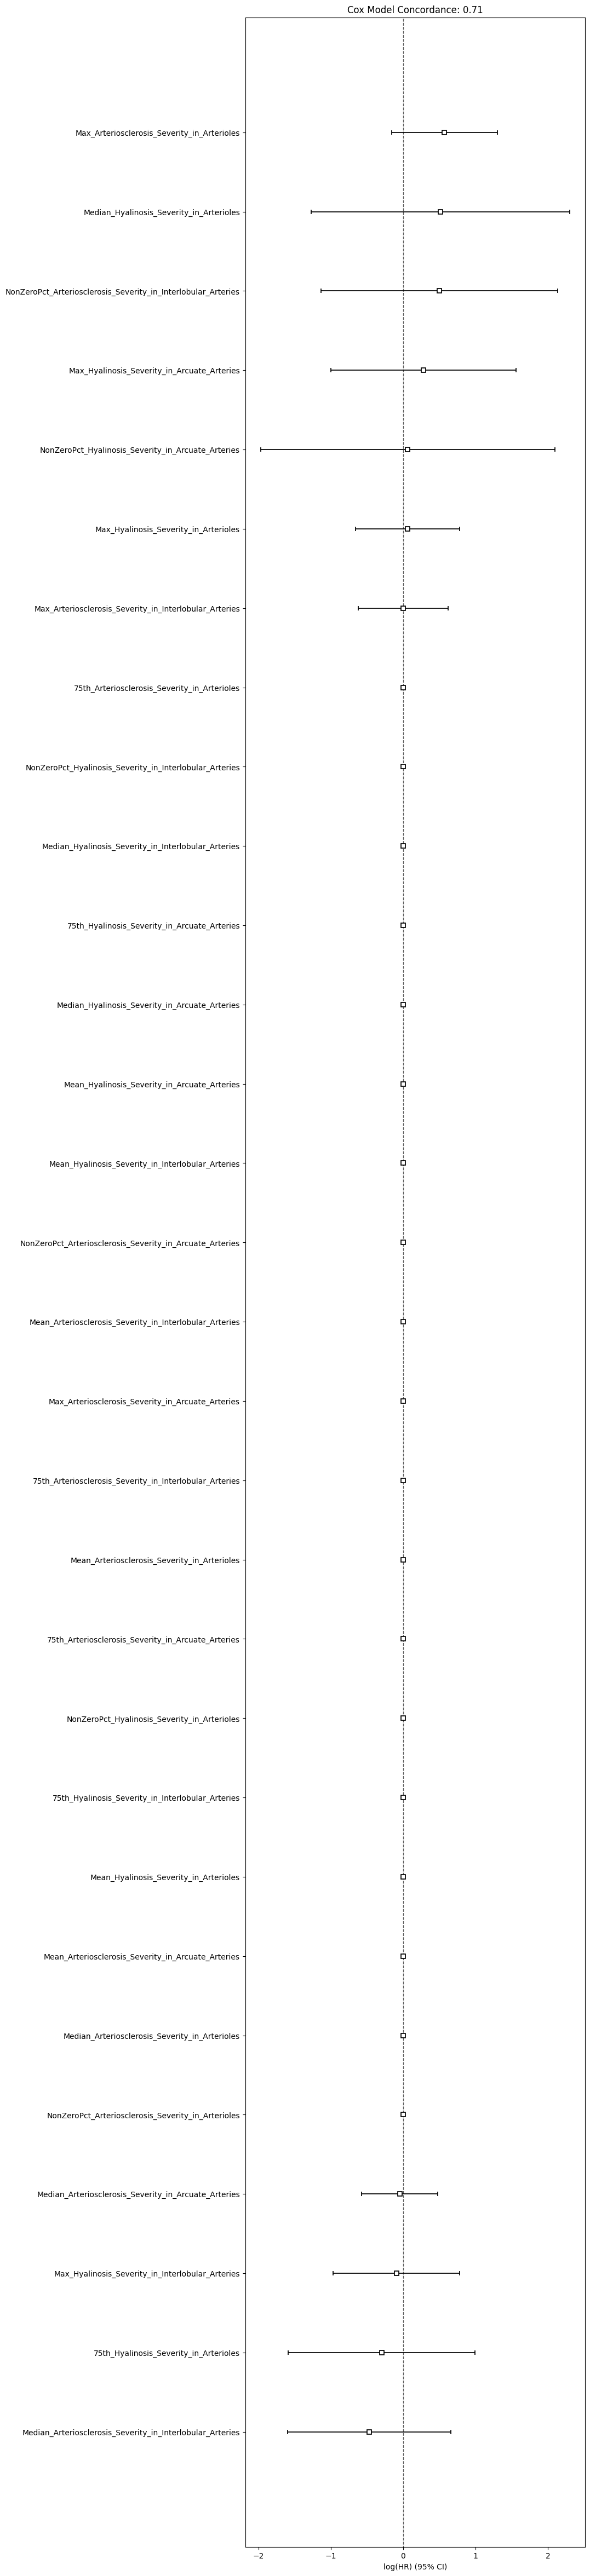

In [56]:
# measurement_features_selected = [x for x in measurement_features if "" in x]
# # score_features_selected = [x for x in score_features if "Arterioles" in x]
# score_features_selected = []

form = "+".join(score_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(8, 60))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed



In [57]:
# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Get the summary of the fitted model
df = cph.summary

# Compute the absolute values of the coefficients and sort them
df['abs_coef'] = df['coef'].abs()
df_sorted = df.sort_values(by='abs_coef', ascending=False)
df_sorted

selected_score_features = df_sorted[df_sorted["abs_coef"] > 0.1].index.values.tolist()

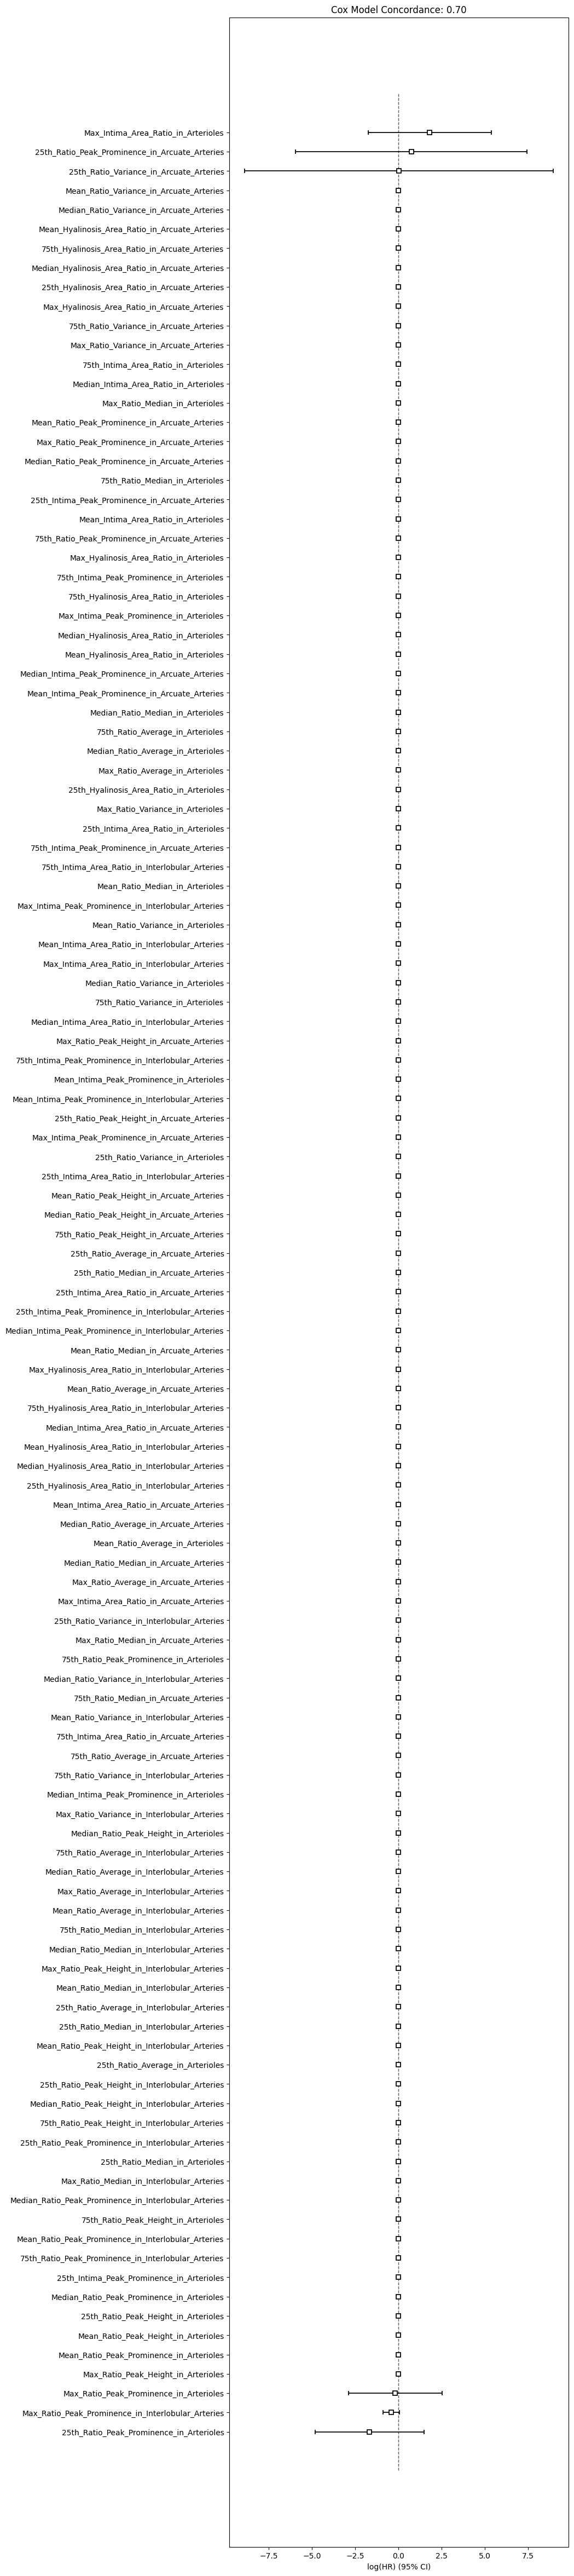

In [11]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(measurement_features_selected)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(8, 60))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [18]:
# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Get the summary of the fitted model
df = cph.summary

# Compute the absolute values of the coefficients and sort them
df['abs_coef'] = df['coef'].abs()
df_sorted = df.sort_values(by='abs_coef', ascending=False)
df_sorted

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),abs_coef
covariate,,,,,,,,,,,,
Max_Intima_Area_Ratio_in_Arterioles,1.806337e+00,6.088104,1.811208,-1.743565,5.356239,0.174896,211.926327,0.0,0.997311,0.318614,1.650119,1.806337e+00
25th_Ratio_Peak_Prominence_in_Arterioles,-1.682952e+00,0.185825,1.605070,-4.828830,1.462927,0.007996,4.318582,0.0,-1.048522,0.294398,1.764161,1.682952e+00
25th_Ratio_Peak_Prominence_in_Arcuate_Arteries,7.436344e-01,2.103567,3.412786,-5.945304,7.432572,0.002618,1690.149690,0.0,0.217897,0.827510,0.273152,7.436344e-01
Max_Ratio_Peak_Prominence_in_Interlobular_Arteries,-4.109939e-01,0.662991,0.240193,-0.881764,0.059777,0.414052,1.061599,0.0,-1.711095,0.087064,3.521788,4.109939e-01
Max_Ratio_Peak_Prominence_in_Arterioles,-1.856178e-01,0.830591,1.378198,-2.886836,2.515600,0.055752,12.374033,0.0,-0.134682,0.892864,0.163488,1.856178e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
Median_Hyalinosis_Area_Ratio_in_Interlobular_Arteries,1.600509e-09,1.000000,0.000304,-0.000597,0.000597,0.999403,1.000597,0.0,0.000005,0.999996,0.000006,1.600509e-09
Mean_Ratio_Average_in_Arterioles,-1.279101e-09,1.000000,0.000438,-0.000858,0.000858,0.999143,1.000858,0.0,-0.000003,0.999998,0.000003,1.279101e-09
25th_Hyalinosis_Area_Ratio_in_Interlobular_Arteries,1.205732e-09,1.000000,0.000304,-0.000597,0.000597,0.999404,1.000597,0.0,0.000004,0.999997,0.000005,1.205732e-09


In [34]:
selected_measurement_features = df_sorted[df_sorted["abs_coef"] > 0.1].index.values.tolist()

In [47]:
CLININCAL_FEATURES_WO_VISUAL = ['PAT_Sex',
 'PAT_Hispanic',
 'PAT_Race',
 'PAT_Cohort',
 'PAT_AgeV3',
 'eGFRatBx',
 'UPCRatBx',
 'Immunosupression_30dBfOrAtBx',
#  'ArterioSclerosis',
#  'ArterialHyalinosis'
 ]

CLININCAL_FEATURES = ['PAT_Sex',
 'PAT_Hispanic',
 'PAT_Race',
 'PAT_Cohort',
 'PAT_AgeV3',
 'eGFRatBx',
 'UPCRatBx',
 'Immunosupression_30dBfOrAtBx',
 'ArterioSclerosis',
 'ArterialHyalinosis'
 ]

In [48]:
pat_df.shape

(198, 372)

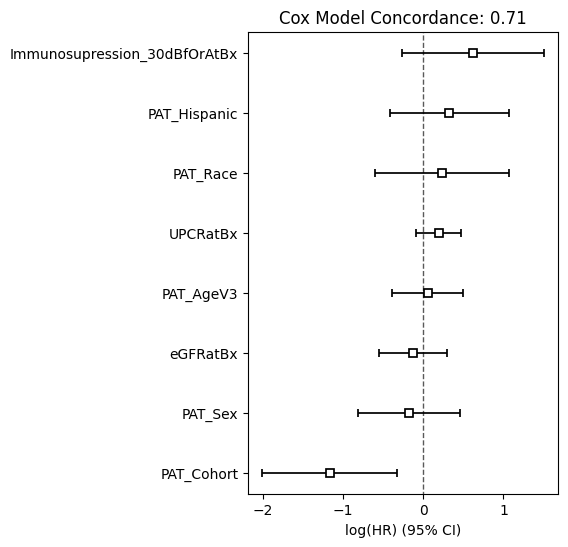

In [53]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES_WO_VISUAL)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

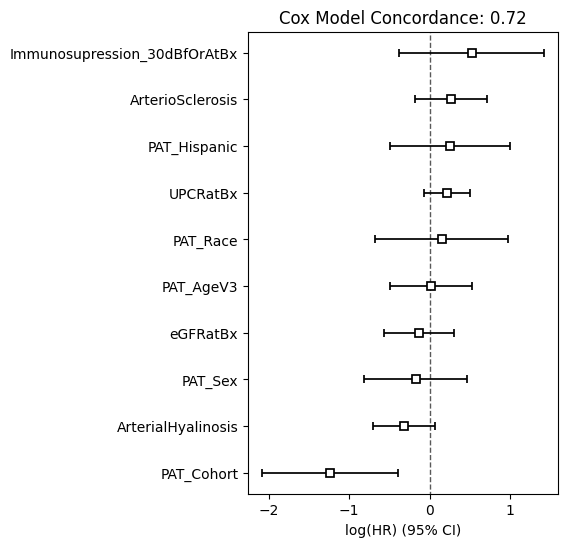

In [54]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

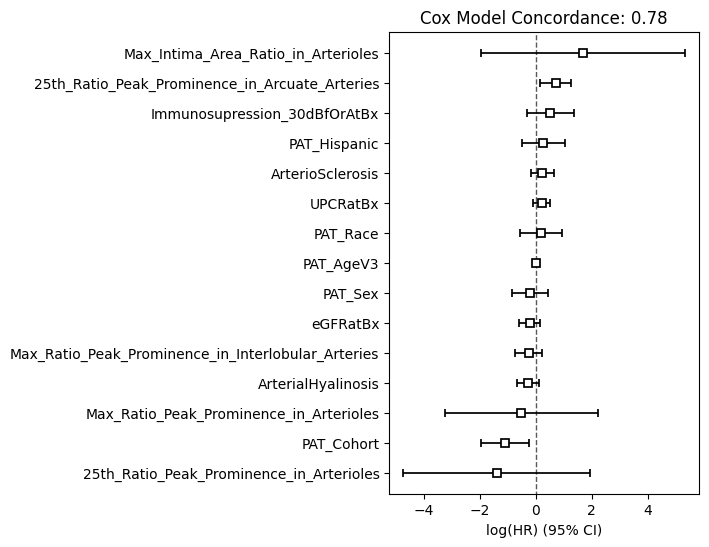

In [55]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES + selected_measurement_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

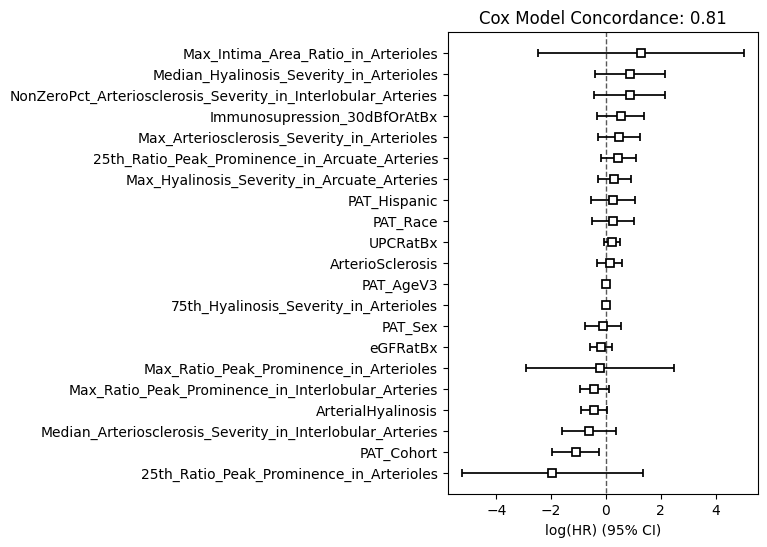

In [59]:
measurement_features_selected = [x for x in measurement_features if "" in x]
# score_features_selected = [x for x in score_features if "Arterioles" in x]
score_features_selected = []

form = "+".join(CLININCAL_FEATURES + selected_score_features+selected_measurement_features)

# Create a figure and axis object with proper dimensions
fig, ax = plt.subplots(figsize=(4, 6))  # Use subplots instead of figure

# Initialize and fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)

# Plotting the hazard ratios for each feature
cph.plot(ax=ax)

# Setting the title with the concordance index
ax.set_title(f"Cox Model Concordance: {cph.concordance_index_:.2f}")
plt.show()  # Ensure the plot is displayed

In [ ]:
# Prepare the plotting area
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(40, 15))  # Adjust the grid size based on the number of features
axes = axes.flatten()  # Flatten the axis array for easy iteration

for idx, feature in enumerate([""] + score_features + selected_measurement_features ):
    # Create the formula including ArterioSclerosis as a common comparison feature
    form = "+".join(CLININCAL_FEATURES)
    if feature != "": 
        form += "+" + feature
        title = "Clinical Features + " + feature
    else:
        title = "Clinical Features"
    # Fit the Cox proportional hazards model
    cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.1)
    cph.fit(pat_df, duration_col='DaysBXtoESRDorEGFR40_LR', event_col='ESRDorEGFR40BX_LR', formula=form)
    # Plotting the hazard ratios for each feature along with ArterioSclerosis
    ax = axes[idx]
    cph.plot(ax=ax)
    ax.set_title(f"{title}: {cph.concordance_index_:.2f}")  # Title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
